# Hypothese 4

In [2]:
import os
from collections import Counter

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import scipy.stats as stats
import seaborn as sns
from scipy.stats import tukey_hsd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

## Daten einlesen

In [3]:
partquet_file_path = "data/input/Data_OpenAlex.parquet"
parquet_dataset = pq.ParquetFile(partquet_file_path)
print(f"Zeilen: {parquet_dataset.metadata.num_rows:,}")
print(f"Row Groups: {parquet_dataset.metadata.num_row_groups}")

Zeilen: 16,751,942
Row Groups: 16


In [4]:
df = pd.read_parquet(partquet_file_path, engine='pyarrow').head(1000)
print(f"Anzahl Spalten: {len(df.columns)}")
print(f"Stichprobe: {len(df)} Zeilen")

Anzahl Spalten: 9
Stichprobe: 1000 Zeilen


In [5]:
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    null_pct = (1000 - non_null) / 1000 * 100

    # Beispielwert
    example = df[col].dropna().iloc[0] if non_null > 0 else "NULL"
    if isinstance(example, str) and len(str(example)) > 30:
        example = str(example)[:30] + "..."

    print(f"{i:2d}. {col:<20} {str(dtype):<12} | Beispiel: {example}")

 1. paper_id             object       | Beispiel: W2889646458
 2. doi                  object       | Beispiel: 10.3322/caac.21492
 3. fwci                 float32      | Beispiel: 4855.44580078125
 4. title                object       | Beispiel: Global cancer statistics 2018:...
 5. publication_year     Int16        | Beispiel: 2018
 6. cited_by_count       int32        | Beispiel: 77106
 7. institution_count    int16        | Beispiel: 2
 8. country_codes        object       | Beispiel: FR,US
 9. institutions         object       | Beispiel: [{"id": "I42237331", "name": "...


## Zusammenhangsanalyse: Kollaborationsgröße vs. FWCI-Dichte

### Deskriptive Analyse

In [6]:
def load_and_clean_data(parquet_dataset, chunk_size=1000000):
    all_institution_counts = []
    all_fwci_values = []
    all_paper_ids = []
    
    total_papers = 0
    valid_papers = 0
    chunk_num = 0
    
    total_rows = parquet_dataset.metadata.num_rows
    
    print(f"Gesamtdatei: {total_rows:,} Zeilen")
    print(f"Chunk-Größe: {chunk_size:,} Zeilen")
    print(f"Erwartete Chunks: {total_rows // chunk_size + 1}")
    
    for batch in parquet_dataset.iter_batches(batch_size=chunk_size):
        chunk_num += 1
        
        # Konvertiere zu Pandas DataFrame
        df_chunk = batch.to_pandas()
        total_papers += len(df_chunk)
        
        # Filtere nur Zeilen mit gültigen institution_count und FWCI-Werten
        df_valid = df_chunk.dropna(subset=['institution_count', 'fwci'])
        df_valid = df_valid[df_valid['fwci'] != 0]  # Ausschluss von FWCI = 0
        
        valid_papers += len(df_valid)
        
        # Sammle alle relevanten Daten
        if len(df_valid) > 0:
            all_institution_counts.extend(df_valid['institution_count'].tolist())
            all_fwci_values.extend(df_valid['fwci'].tolist())
            all_paper_ids.extend(df_valid['paper_id'].tolist())
        
        # Progress Update
        if chunk_num % 5 == 0:
            progress = (chunk_num * chunk_size) / total_rows * 100
            print(f"     Chunk {chunk_num:2d}: {progress:5.1f}% | "
                    f"Valid: {valid_papers:,} | Aktuell gesammelt: {len(all_fwci_values):,}")
    
    print(f"Gesamte Papers: {total_papers:,}")
    print(f"Gültige Papers (mit Institution Count & FWCI): {valid_papers:,}")
    
    # Erstelle finalen DataFrame aus gesammelten Daten
    df_clean = pd.DataFrame({
        'paper_id': all_paper_ids,
        'institution_count': all_institution_counts,
        'fwci': all_fwci_values
    })
        
    return df_clean

df_analysis = load_and_clean_data(parquet_dataset)
print(f"Finale Daten: {len(df_analysis):,} Paper mit Institution & FWCI-Daten")

Gesamtdatei: 16,751,942 Zeilen
Chunk-Größe: 1,000,000 Zeilen
Erwartete Chunks: 17
     Chunk  5:  29.8% | Valid: 3,050,377 | Aktuell gesammelt: 3,050,377
     Chunk 10:  59.7% | Valid: 5,823,555 | Aktuell gesammelt: 5,823,555
     Chunk 15:  89.5% | Valid: 8,685,950 | Aktuell gesammelt: 8,685,950
Gesamte Papers: 16,751,942
Gültige Papers (mit Institution Count & FWCI): 9,231,443
Finale Daten: 9,231,443 Paper mit Institution & FWCI-Daten


In [7]:
# Analysiere Institution Count Verteilung
inst_counts = df_analysis['institution_count'].value_counts().sort_index()
print(f"Institutionen-Anzahl Verteilung:")
print(f"  Min: {df_analysis['institution_count'].min()}")
print(f"  Max: {df_analysis['institution_count'].max()}")
print(f"  Median: {df_analysis['institution_count'].median()}")
print(f"  95. Perzentil: {df_analysis['institution_count'].quantile(0.95)}")

Institutionen-Anzahl Verteilung:
  Min: 1
  Max: 251
  Median: 2.0
  95. Perzentil: 8.0


In [8]:
print(f"Top 10 Institutionen-Anzahlen:")
for count, freq in inst_counts.head(10).items():
    percentage = freq / len(df_analysis) * 100
    print(f"  {count} Institutionen: {freq:,} Papers ({percentage:.1f}%)")

Top 10 Institutionen-Anzahlen:
  1 Institutionen: 2,944,865 Papers (31.9%)
  2 Institutionen: 2,303,295 Papers (25.0%)
  3 Institutionen: 1,465,875 Papers (15.9%)
  4 Institutionen: 886,763 Papers (9.6%)
  5 Institutionen: 535,802 Papers (5.8%)
  6 Institutionen: 330,344 Papers (3.6%)
  7 Institutionen: 210,237 Papers (2.3%)
  8 Institutionen: 136,746 Papers (1.5%)
  9 Institutionen: 92,635 Papers (1.0%)
  10 Institutionen: 64,265 Papers (0.7%)


In [9]:
# FWCI Verteilung
fwci_stats = df_analysis['fwci'].describe()
print(f"FWCI-Statistiken:")
print(f"  Min: {fwci_stats['min']:.2f}")
print(f"  25%: {fwci_stats['25%']:.2f}")
print(f"  Median: {fwci_stats['50%']:.2f}")
print(f"  75%: {fwci_stats['75%']:.2f}")
print(f"  Max: {fwci_stats['max']:.2f}")

FWCI-Statistiken:
  Min: 0.01
  25%: 0.51
  Median: 1.18
  75%: 2.61
  Max: 8154.95


### Gruppierung und Visualisierung

In [10]:
def prepare_datasets_for_plot(df_data):
    """
    Erstellt wissenschaftlich sinnvolle Gruppen und bereitet Daten für die Visualisierung vor
    """
    # Wissenschaftlich sinnvolle Gruppierung basierend auf der Datenverteilung
    def categorize_institutions(count):
        if count == 1:
            return "Einzelinstitution (1)"
        elif count == 2:
            return "Kleine Kollaboration (2)"
        elif count in [3, 4]:
            return "Mittlere Kollaboration (3-4)"
        elif count in [5, 6, 7, 8]:
            return "Große Kollaboration (5-8)"
        elif count in range(9, 16):
            return "Sehr große Kollaboration (9-15)"
        else:
            return "Mega-Kollaboration (≥16)"
    
    df_data['institution_group'] = df_data['institution_count'].apply(categorize_institutions)
    
    # Gruppenstatistiken mit allen Daten
    print(f"Gruppen-Statistiken (basierend auf allen {len(df_data):,} Papers):")
    for group in ["Einzelinstitution (1)", "Kleine Kollaboration (2)", 
                  "Mittlere Kollaboration (3-4)", "Große Kollaboration (5-8)",
                  "Sehr große Kollaboration (9-15)", "Mega-Kollaboration (≥16)"]:
        if group in df_data['institution_group'].values:
            group_data = df_data[df_data['institution_group'] == group]
            n_papers = len(group_data)
            mean_fwci = group_data['fwci'].mean()
            median_fwci = group_data['fwci'].median()
            percentage = n_papers / len(df_data) * 100
            
            print(f"{group:<30} | {n_papers:>6,} Papers ({percentage:>5.1f}%) | "
                  f"FWCI: mean={mean_fwci:>6.2f}, median={median_fwci:>6.2f}")
    
    # Bereite Daten für Plot vor
    # Begrenze FWCI-Werte auf maximal 6 für bessere Visualisierung
    df_plot = df_data[df_data['fwci'] <= 6].copy()
    
    excluded_papers = len(df_data) - len(df_plot)
    exclusion_percent = (excluded_papers / len(df_data)) * 100
    
    print(f"\nVerwende alle {len(df_plot):,} Papers für Visualisierung (FWCI ≤ 6)")
    print(f"Ausgeschlossen: {excluded_papers:,} Papers mit FWCI > 6 ({exclusion_percent:.2f}%)")
    
    # Sortiere Gruppen in logischer Reihenfolge
    group_order = ["Einzelinstitution (1)", "Kleine Kollaboration (2)", 
                   "Mittlere Kollaboration (3-4)", "Große Kollaboration (5-8)",
                   "Sehr große Kollaboration (9-15)", "Mega-Kollaboration (≥16)"]
    
    # Filtere nur existierende Gruppen
    existing_groups = [g for g in group_order if g in df_plot['institution_group'].values]
    
    
    return df_data, df_plot, existing_groups

# Erstelle Gruppierung und Visualisierung
df_data, df_plot, existing_groups = prepare_datasets_for_plot(df_analysis)

Gruppen-Statistiken (basierend auf allen 9,231,443 Papers):
Einzelinstitution (1)          | 2,944,865 Papers ( 31.9%) | FWCI: mean=  2.23, median=  0.99
Kleine Kollaboration (2)       | 2,303,295 Papers ( 25.0%) | FWCI: mean=  2.35, median=  1.10
Mittlere Kollaboration (3-4)   | 2,352,638 Papers ( 25.5%) | FWCI: mean=  2.53, median=  1.25
Große Kollaboration (5-8)      | 1,213,129 Papers ( 13.1%) | FWCI: mean=  2.89, median=  1.46
Sehr große Kollaboration (9-15) | 304,665 Papers (  3.3%) | FWCI: mean=  4.00, median=  1.87
Mega-Kollaboration (≥16)       | 112,851 Papers (  1.2%) | FWCI: mean=  7.54, median=  2.80

Verwende alle 8,445,553 Papers für Visualisierung (FWCI ≤ 6)
Ausgeschlossen: 785,890 Papers mit FWCI > 6 (8.51%)


In [11]:
# Definiere Basis-Farben (EU-Stil)
base_blue = '#00257C'    # Dunkelblau
base_yellow = '#FFC620'  # Orange/Gelb

# Erstelle Farbpalette für die Anzahl der existierenden Gruppen
n_groups = len(existing_groups)

def create_grouped_colors(base_blue, base_yellow, n_groups):
    """Erstelle gruppierte Farben mit erste Hälfte Blautöne, zweite Hälfte Gelbtöne"""
    colors = []
    
    # Berechne wie viele Gruppen pro Farbe
    mid_point = n_groups // 2
    blue_groups = mid_point if n_groups % 2 == 0 else mid_point + 1
    yellow_groups = n_groups - blue_groups
    
    # Konvertiere Hex zu RGB
    blue_rgb = mcolors.hex2color(base_blue)
    yellow_rgb = mcolors.hex2color(base_yellow)
    
    # Erstelle Blautöne (von dunkel zu hell)
    for i in range(blue_groups):
        # Alpha-Wert von 1.0 zu 0.6 (dunkler zu heller)
        alpha = 1.0 - (i * 0.2)
        alpha = max(alpha, 0.6)
        
        # Mische mit Weiß für hellere Töne
        mix_factor = i * 0.05
        r = blue_rgb[0] * (1 - mix_factor) + 1.0 * mix_factor
        g = blue_rgb[1] * (1 - mix_factor) + 1.0 * mix_factor
        b = blue_rgb[2] * (1 - mix_factor) + 1.0 * mix_factor
        
        colors.append((r, g, b, alpha))
    
    for i in range(yellow_groups):
        alpha = 0.6 + (i / (yellow_groups - 1)) * 0.4 if yellow_groups > 1 else 1.0
        
        # Mische mit Weiß, erste Gruppe hat meiste Weißmischung, letzte hat keine
        mix_factor = ((yellow_groups - 1 - i) / (yellow_groups - 1)) * 0.4 if yellow_groups > 1 else 0
        r = yellow_rgb[0] * (1 - mix_factor) + 1.0 * mix_factor
        g = yellow_rgb[1] * (1 - mix_factor) + 1.0 * mix_factor
        b = yellow_rgb[2] * (1 - mix_factor) + 1.0 * mix_factor
        
        colors.append((r, g, b, alpha))
    
    return colors

# Erstelle Farbpalette
custom_colors = create_grouped_colors(base_blue, base_yellow, n_groups)

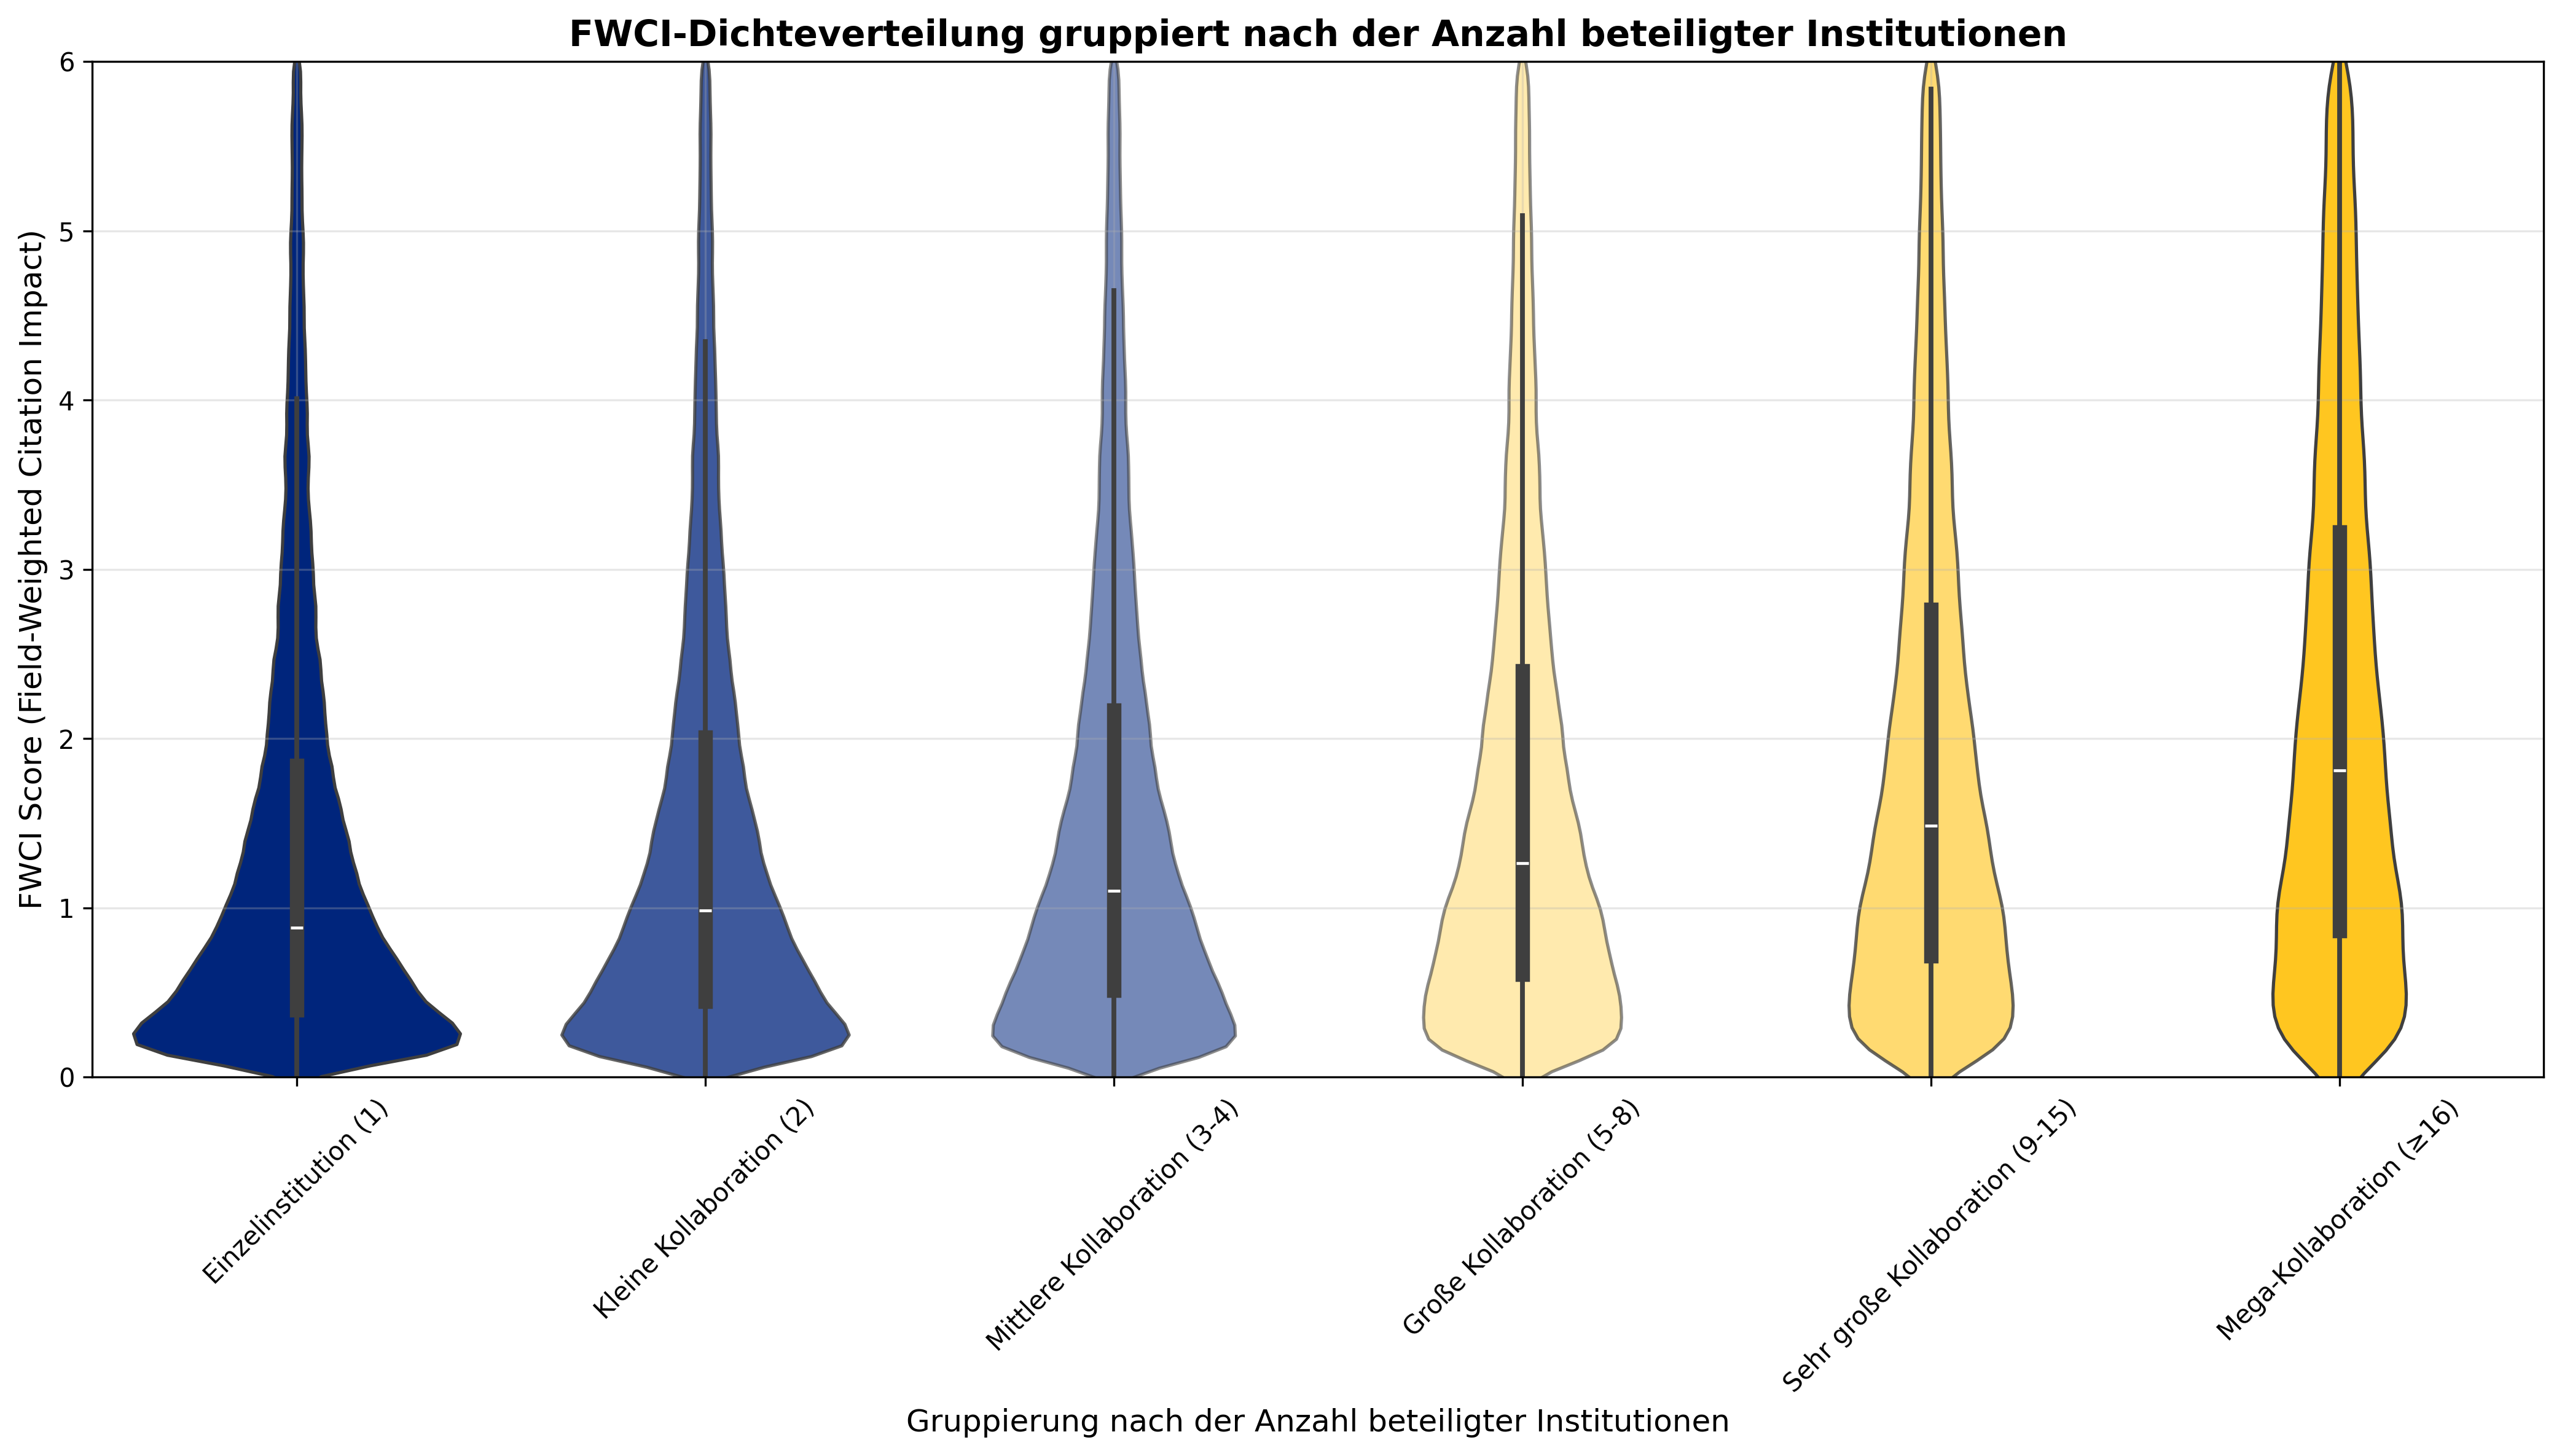

In [12]:
# Erstelle Violin Plot
plt.figure(figsize=(14, 8), dpi=300)
plt.rcParams['svg.fonttype'] = 'none'
ax = sns.violinplot(data=df_plot, x='institution_group', y='fwci', 
                    order=existing_groups)

# Wende Farben an
for i, patch in enumerate(ax.collections):
    if i < len(custom_colors):
        color = custom_colors[i]
        patch.set_facecolor(color[:3])
        patch.set_alpha(color[3])

plt.title('FWCI-Dichteverteilung gruppiert nach der Anzahl beteiligter Institutionen', 
            fontsize=14, fontweight='bold')
plt.xlabel('Gruppierung nach der Anzahl beteiligter Institutionen', fontsize=12)
plt.ylabel('FWCI Score (Field-Weighted Citation Impact)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(0, 6)

plt.tight_layout()

plot_path = 'data/output/Hypothese_4.svg'
plt.savefig(plot_path, format='svg', bbox_inches='tight', dpi=300)
plt.show()

## Statistische Kennzahlen

### Datenaufbereitung für statistische Analyse

In [13]:
df_stats = df_analysis.copy()
data_source = f"({len(df_stats):,} Papers)"
print(f"Analysiere {data_source}")
print(f"Gültige Datenpunkte: {len(df_stats):,}")

Analysiere (9,231,443 Papers)
Gültige Datenpunkte: 9,231,443


In [14]:
# Gruppierung anwenden
def categorize_institutions(count):
    if count == 1:
        return "Einzelinstitution (1)"
    elif count == 2:
        return "Kleine Kollaboration (2)"
    elif count in [3, 4]:
        return "Mittlere Kollaboration (3-4)"
    elif count in [5, 6, 7, 8]:
        return "Große Kollaboration (5-8)"
    elif count in range(9, 16):
        return "Sehr große Kollaboration (9-15)"
    else:
        return "Mega-Kollaboration (≥16)"

df_stats['institution_group'] = df_stats['institution_count'].apply(categorize_institutions)

### Deskriptive Statistik

In [15]:
print(f"Institution Count:")
print(f"  Bereich: {df_stats['institution_count'].min()} - {df_stats['institution_count'].max()}")
print(f"  Mittelwert: {df_stats['institution_count'].mean():.2f}")
print(f"  Median: {df_stats['institution_count'].median():.1f}")
print(f"  Standardabweichung: {df_stats['institution_count'].std():.2f}")
print(f"  95. Perzentil: {df_stats['institution_count'].quantile(0.95):.1f}")

Institution Count:
  Bereich: 1 - 251
  Mittelwert: 3.13
  Median: 2.0
  Standardabweichung: 3.65
  95. Perzentil: 8.0


In [16]:
print(f"FWCI-Scores:")
print(f"  Bereich: {df_stats['fwci'].min():.3f} - {df_stats['fwci'].max():.3f}")
print(f"  Mittelwert: {df_stats['fwci'].mean():.3f}")
print(f"  Median: {df_stats['fwci'].median():.3f}")
print(f"  Standardabweichung: {df_stats['fwci'].std():.3f}")
print(f"  Schiefe: {stats.skew(df_stats['fwci']):.3f}")
print(f"  Kurtosis: {stats.kurtosis(df_stats['fwci']):.3f}")

FWCI-Scores:
  Bereich: 0.009 - 8154.949
  Mittelwert: 2.548
  Median: 1.178
  Standardabweichung: 8.426
  Schiefe: 241.638
  Kurtosis: 165845.068


### Gruppierte Statistik nach Institutionenanzahl

In [17]:
group_stats = {}
for group in df_stats['institution_group'].unique():
    group_data = df_stats[df_stats['institution_group'] == group]['fwci']
    
    stats_dict = {
        'n': len(group_data),
        'mean': group_data.mean(),
        'median': group_data.median(),
        'std': group_data.std(),
        'min': group_data.min(),
        'max': group_data.max(),
        'q25': group_data.quantile(0.25),
        'q75': group_data.quantile(0.75),
        'skewness': stats.skew(group_data),
        'kurtosis': stats.kurtosis(group_data)
    }
    group_stats[group] = stats_dict

# Sortiere Gruppen in logischer Reihenfolge
group_order = [
    "Einzelinstitution (1)", "Kleine Kollaboration (2)", 
    "Mittlere Kollaboration (3-4)", "Große Kollaboration (5-8)",
    "Sehr große Kollaboration (9-15)", "Mega-Kollaboration (≥16)"
]

existing_groups = [g for g in group_order if g in group_stats.keys()]

print(f"{'Gruppe':<30} | {'n':<8} | {'Mean':<8} | {'Median':<8} | {'Std':<8} | {'Schiefe':<8}")
for group in existing_groups:
    stats_group = group_stats[group]
    print(f"{group:<30} | {stats_group['n']:<8,} | {stats_group['mean']:<8.3f} | "
          f"{stats_group['median']:<8.3f} | {stats_group['std']:<8.3f} | {stats_group['skewness']:<8.3f}")

Gruppe                         | n        | Mean     | Median   | Std      | Schiefe 
Einzelinstitution (1)          | 2,944,865 | 2.228    | 0.988    | 6.485    | 78.421  
Kleine Kollaboration (2)       | 2,303,295 | 2.355    | 1.101    | 9.719    | 423.858 
Mittlere Kollaboration (3-4)   | 2,352,638 | 2.530    | 1.245    | 7.582    | 264.219 
Große Kollaboration (5-8)      | 1,213,129 | 2.892    | 1.462    | 7.289    | 54.486  
Sehr große Kollaboration (9-15) | 304,665  | 4.005    | 1.866    | 11.381   | 40.021  
Mega-Kollaboration (≥16)       | 112,851  | 7.540    | 2.800    | 25.049   | 33.545  


### Korrelationsanalyse

In [18]:
# Pearson-Korrelation (lineare Beziehung)
pearson_corr, pearson_p = stats.pearsonr(df_stats['institution_count'], df_stats['fwci'])
print(f"Pearson-Korrelation:")
print(f"  r = {pearson_corr:.4f}")
print(f"  p-value = {pearson_p:.2e}")
print(f"  Signifikanz (α=0.001): {'***' if pearson_p < 0.001 else '**' if pearson_p < 0.01 else '*' if pearson_p < 0.05 else 'n.s.'}")

Pearson-Korrelation:
  r = 0.0826
  p-value = 0.00e+00
  Signifikanz (α=0.001): ***


In [19]:
# Spearman-Korrelation (monotone Beziehung)
spearman_corr, spearman_p = stats.spearmanr(df_stats['institution_count'], df_stats['fwci'])
print(f"Spearman-Korrelation:")
print(f"  ρ = {spearman_corr:.4f}")
print(f"  p-value = {spearman_p:.2e}")
print(f"  Signifikanz (α=0.001): {'***' if spearman_p < 0.001 else '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else 'n.s.'}")

Spearman-Korrelation:
  ρ = 0.1300
  p-value = 0.00e+00
  Signifikanz (α=0.001): ***


In [20]:
# Kendall-Tau (robuste Rang-Korrelation)
kendall_corr, kendall_p = stats.kendalltau(df_stats['institution_count'], df_stats['fwci'])
print(f"Kendall-Tau:")
print(f"  τ = {kendall_corr:.4f}")
print(f"  p-value = {kendall_p:.2e}")
print(f"  Signifikanz (α=0.001): {'***' if kendall_p < 0.001 else '**' if kendall_p < 0.01 else '*' if kendall_p < 0.05 else 'n.s.'}")

Kendall-Tau:
  τ = 0.0951
  p-value = 0.00e+00
  Signifikanz (α=0.001): ***


In [21]:
# Interpretation der Korrelationsstärke
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r < 0.1:
        return "Vernachlässigbar"
    elif abs_r < 0.3:
        return "Schwach"
    elif abs_r < 0.5:
        return "Moderat"
    elif abs_r < 0.7:
        return "Stark"
    else:
        return "Sehr stark"

print(f"Interpretation:")
print(f"  Pearson-Stärke: {interpret_correlation(pearson_corr)}")
print(f"  Spearman-Stärke: {interpret_correlation(spearman_corr)}")

Interpretation:
  Pearson-Stärke: Vernachlässigbar
  Spearman-Stärke: Schwach


### Regressionsanalyse

In [22]:
X = df_stats['institution_count'].values.reshape(-1, 1)
y = df_stats['fwci'].values

# Lineare Regression
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)
r2_linear = r2_score(y, y_pred_linear)

print(f"Lineare Regression: FWCI = β₀ + β₁ × Institution_Count")
print(f"  Achsenabschnitt (β₀): {linear_model.intercept_:.4f}")
print(f"  Steigung (β₁): {linear_model.coef_[0]:.4f}")
print(f"  R² (linear): {r2_linear:.4f}")
print(f"  Interpretation: Pro zusätzliche Institution → FWCI steigt um {linear_model.coef_[0]:.4f}")

Lineare Regression: FWCI = β₀ + β₁ × Institution_Count
  Achsenabschnitt (β₀): 1.9497
  Steigung (β₁): 0.1907
  R² (linear): 0.0068
  Interpretation: Pro zusätzliche Institution → FWCI steigt um 0.1907


In [23]:
# Polynomielle Regression (Grad 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)
r2_poly = r2_score(y, y_pred_poly)

print(f"Polynomielle Regression (Grad 2):")
print(f"  R² (polynomial): {r2_poly:.4f}")
print(f"  Verbesserung über linear: {r2_poly - r2_linear:.4f}")

Polynomielle Regression (Grad 2):
  R² (polynomial): 0.0068
  Verbesserung über linear: 0.0000


In [24]:
# Logarithmische Transformation
log_institution = np.log1p(df_stats['institution_count'])  # log(1+x) um log(0) zu vermeiden
log_corr, log_p = stats.pearsonr(log_institution, df_stats['fwci'])

print(f"Logarithmische Beziehung:")
print(f"  Korrelation log(Institution) vs FWCI: r = {log_corr:.4f}")
print(f"  p-value: {log_p:.2e}")

Logarithmische Beziehung:
  Korrelation log(Institution) vs FWCI: r = 0.0646
  p-value: 0.00e+00


### Varianzanalyse

In [25]:
# Sammle FWCI-Daten für jede Gruppe
group_fwci_data = []
for group in existing_groups:
    group_data = df_stats[df_stats['institution_group'] == group]['fwci'].values
    group_fwci_data.append(group_data)

# Einfaktorielle ANOVA
f_stat, anova_p = stats.f_oneway(*group_fwci_data)

print(f"Einfaktorielle ANOVA:")
print(f"  F-Statistik: {f_stat:.4f}")
print(f"  p-value: {anova_p:.2e}")
print(f"  Signifikanz: {'***' if anova_p < 0.001 else '**' if anova_p < 0.01 else '*' if anova_p < 0.05 else 'n.s.'}")
print(f"  Interpretation: {'Signifikante' if anova_p < 0.05 else 'Keine signifikanten'} Unterschiede zwischen den Gruppen")

Einfaktorielle ANOVA:
  F-Statistik: 11310.5511
  p-value: 0.00e+00
  Signifikanz: ***
  Interpretation: Signifikante Unterschiede zwischen den Gruppen


In [26]:
# Effektstärke (Eta-squared)
ss_between = sum([len(group) * (np.mean(group) - np.mean(df_stats['fwci']))**2 for group in group_fwci_data])
ss_total = np.sum((df_stats['fwci'] - np.mean(df_stats['fwci']))**2)
eta_squared = ss_between / ss_total

print(f"Effektstärke (η²): {eta_squared:.4f}")
effect_interpretation = "Klein" if eta_squared < 0.06 else "Mittel" if eta_squared < 0.14 else "Groß"
print(f"Effekt-Interpretation: {effect_interpretation}")

Effektstärke (η²): 0.0061
Effekt-Interpretation: Klein


In [27]:
# Post-HOC Tests (Tukey's HSD)
tukey_result = tukey_hsd(*group_fwci_data)

print(f"Tukey HSD Test:")
print(f"  Anzahl Vergleiche: {len(existing_groups) * (len(existing_groups) - 1) // 2}")

# Zeige signifikante Unterschiede
significant_pairs = []
for i in range(len(existing_groups)):
    for j in range(i + 1, len(existing_groups)):
        if tukey_result.pvalue[i, j] < 0.05:
            mean_diff = np.mean(group_fwci_data[j]) - np.mean(group_fwci_data[i])
            significant_pairs.append((existing_groups[i], existing_groups[j], mean_diff, tukey_result.pvalue[i, j]))

print(f"  Signifikante Unterschiede (p < 0.05): {len(significant_pairs)}")

if significant_pairs:
    print(f"\n  Größte Unterschiede in absteigender Reihenfolge:")
    significant_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for i, (group1, group2, diff, p_val) in enumerate(significant_pairs):
        print(f"    {i+1}. {group1} vs {group2}: Delta={diff:+.3f} (p={p_val:.4f})")

Tukey HSD Test:
  Anzahl Vergleiche: 15
  Signifikante Unterschiede (p < 0.05): 15

  Größte Unterschiede in absteigender Reihenfolge:
    1. Einzelinstitution (1) vs Mega-Kollaboration (≥16): Delta=+5.312 (p=0.0000)
    2. Kleine Kollaboration (2) vs Mega-Kollaboration (≥16): Delta=+5.186 (p=0.0000)
    3. Mittlere Kollaboration (3-4) vs Mega-Kollaboration (≥16): Delta=+5.011 (p=0.0000)
    4. Große Kollaboration (5-8) vs Mega-Kollaboration (≥16): Delta=+4.648 (p=0.0000)
    5. Sehr große Kollaboration (9-15) vs Mega-Kollaboration (≥16): Delta=+3.536 (p=0.0000)
    6. Einzelinstitution (1) vs Sehr große Kollaboration (9-15): Delta=+1.776 (p=0.0000)
    7. Kleine Kollaboration (2) vs Sehr große Kollaboration (9-15): Delta=+1.650 (p=0.0000)
    8. Mittlere Kollaboration (3-4) vs Sehr große Kollaboration (9-15): Delta=+1.475 (p=0.0000)
    9. Große Kollaboration (5-8) vs Sehr große Kollaboration (9-15): Delta=+1.112 (p=0.0000)
    10. Einzelinstitution (1) vs Große Kollaboration (5-8): D

### Trend Tests

In [28]:
# Spearman-Korrelation mit ordinalen Gruppen
group_means = [group_stats[group]['mean'] for group in existing_groups]
group_positions = list(range(1, len(existing_groups) + 1))

trend_corr, trend_p = stats.spearmanr(group_positions, group_means)
print(f"Spearman ρ (Position vs Mittelwert): {trend_corr:.4f}")
print(f"  p-value: {trend_p:.4f}")
print(f"  Trend: {'Signifikant steigend' if trend_corr > 0 and trend_p < 0.05 else 'Kein signifikanter Trend'}")

Spearman ρ (Position vs Mittelwert): 1.0000
  p-value: 0.0000
  Trend: Signifikant steigend


### Effektgrößen

In [29]:
# Cohen's d zwischen extremen Gruppen
group1_data = df_stats[df_stats['institution_group'] == existing_groups[0]]['fwci']
group_last_data = df_stats[df_stats['institution_group'] == existing_groups[-1]]['fwci']

mean_diff = group_last_data.mean() - group1_data.mean()
pooled_std = np.sqrt(((group1_data.std()**2 * (len(group1_data) - 1)) + 
                      (group_last_data.std()**2 * (len(group_last_data) - 1))) / 
                     (len(group1_data) + len(group_last_data) - 2))
cohens_d = mean_diff / pooled_std

print(f"Cohen's d ({existing_groups[0]} vs {existing_groups[-1]}):")
print(f"  d = {cohens_d:.4f}")
effect_size = "Klein" if abs(cohens_d) < 0.5 else "Mittel" if abs(cohens_d) < 0.8 else "Groß"
print(f"  Effektgröße: {effect_size}")

# Glass's Delta (robuster gegen ungleiche Varianzen)
glass_delta = mean_diff / group1_data.std()
print(f"  Glass's Delta = {glass_delta:.4f}")

Cohen's d (Einzelinstitution (1) vs Mega-Kollaboration (≥16)):
  d = 0.6658
  Effektgröße: Mittel
  Glass's Delta = 0.8191


### Robustheits Tests

In [30]:
# Levene Test für Varianzhomogenität
levene_stat, levene_p = stats.levene(*group_fwci_data)
print(f"Levene Test (Varianzhomogenität):")
print(f"  Statistik: {levene_stat:.4f}")
print(f"  p-value: {levene_p:.4f}")
print(f"  Varianzen: {'Homogen' if levene_p > 0.05 else 'Heterogen'}")

Levene Test (Varianzhomogenität):
  Statistik: 7967.6796
  p-value: 0.0000
  Varianzen: Heterogen


In [31]:
# Kruskal-Wallis Test (nicht-parametrische ANOVA)
kw_stat, kw_p = stats.kruskal(*group_fwci_data)
print(f"Kruskal-Wallis Test (nicht-parametrisch):")
print(f"  H-Statistik: {kw_stat:.4f}")
print(f"  p-value: {kw_p:.2e}")
print(f"  Signifikanz: {'***' if kw_p < 0.001 else '**' if kw_p < 0.01 else '*' if kw_p < 0.05 else 'n.s.'}")

Kruskal-Wallis Test (nicht-parametrisch):
  H-Statistik: 187630.1027
  p-value: 0.00e+00
  Signifikanz: ***
